# Include Latitude and Longitude in Post-processed WRF

The purpose of this notebook is to include the latitude and longitude values originally present in the WRF data (as geolocation grids) in the final post-processed output data.

#### Current post-processed file structure

A current copy (as of 2021-10-13) was saved to the project directory on Poseidon for reference via 
```
cp /rcs/project_data/wrf_data/wind-issue/hourly_fix/u10/u10_hourly_wrf_NCAR-CCSM4_rcp85_2006.nc include-latlon/u10_ccsm_2006_original_copy.nc
```

View this file:

In [4]:
import os
from pathlib import Path
import xarray as xr


base_dir = Path(os.getenv("BASE_DIR"))
latlon_dir = base_dir.joinpath("include-latlon")
original_fp = latlon_dir.joinpath("u10_ccsm_2006_original_copy.nc")

with xr.open_dataset(original_fp) as ds:
    print(ds)
    test_arr = ds["u10"].sel(time="2006-01-01T00:00:00").values

<xarray.Dataset>
Dimensions:  (time: 8760, yc: 262, xc: 262)
Coordinates:
  * xc       (xc) float64 -2.61e+06 -2.59e+06 -2.57e+06 ... 2.59e+06 2.61e+06
  * yc       (yc) float64 -1.824e+05 -2.024e+05 ... -5.382e+06 -5.402e+06
  * time     (time) datetime64[ns] 2006-01-01 ... 2006-12-31T23:00:00
Data variables:
    u10      (time, yc, xc) float32 ...
Attributes:
    creation_date:    Sat May 13 13:02:24 AKDT 2017
    NCL_Version:      6.3.0
    system:           Linux n9 2.6.32-642.11.1.el6.686g0000.x86_64 #1 SMP Tue...
    Conventions:      None
    grib_source:      WRFDS_d01.2006-01-01_00.grib
    title:            NCL: convert-GRIB-to-netCDF
    reference_time:   2006-01-01 00:00:00
    proj_parameters:  +units=m +proj=stere +lat_ts=64.0 +lon_0=-152.0 +lat_0=...
    crs_wkt:          PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknow...
    restacked_by:     Scenarios Network for Alaska + Arctic Planning -- 2018
    SNAP_VERSION:     1.0


#### Stacked data with lat/lon info

The "stacked" data resulting from pipeline is to be removed, but it still has the lat/lon info that we wish to add. An original stacked file was copied to the `$BASE_DIR/include-latlon/` for reference and for future extraction the lat/lon grids, since all stacked data have the same lat/lon grids. This was accomplished with: 

```
cp /rcs/project_data/wrf_data/wind-issue/hourly/u10/U10_wrf_hourly_ccsm_rcp85_2006.nc  include-latlon/u10_ccsm_2006_stacked_original_copy.nc
```

Now view the "stacked" data file copy, and extract the lat/lon grids:

In [30]:
original_stacked_fp = latlon_dir.joinpath("u10_ccsm_2006_stacked_original_copy.nc")

with xr.open_dataset(original_stacked_fp) as stacked_ds:
    print(stacked_ds)
    lat_arr = stacked_ds["lat"].values
    lon_arr = stacked_ds["lon"].values
    test_stacked_arr = stacked_ds["U10"].sel(time="2006-01-01T00:00:00").values

print("\nLatitude grid:\n", lat_arr)
print("\nLongitude grid:\n", lon_arr)

<xarray.Dataset>
Dimensions:  (time: 8760, x: 262, y: 262)
Coordinates:
    lon      (x, y) float32 ...
    lat      (x, y) float32 ...
  * time     (time) datetime64[ns] 2006-01-01 ... 2006-12-31T23:00:00
Dimensions without coordinates: x, y
Data variables:
    U10      (time, x, y) float32 ...
Attributes:
    creation_date:    Sat May 13 13:02:24 AKDT 2017
    NCL_Version:      6.3.0
    system:           Linux n9 2.6.32-642.11.1.el6.686g0000.x86_64 #1 SMP Tue...
    Conventions:      None
    grib_source:      WRFDS_d01.2006-01-01_00.grib
    title:            NCL: convert-GRIB-to-netCDF
    reference_time:   2006-01-01 00:00:00
    proj_parameters:  +units=m +proj=stere +lat_ts=64.0 +lon_0=-152.0 +lat_0=...

Latitude grid:
 [[37.233    37.29895  37.364525 ... 37.367493 37.301937 37.236   ]
 [37.369934 37.43616  37.50201  ... 37.504993 37.439156 37.372944]
 [37.506927 37.573433 37.639565 ... 37.642555 37.576443 37.509953]
 ...
 [65.55994  65.740295 65.92076  ... 65.928955 65.74848  

#### Invert the grids vertically

The grid is flipped vertically in the final step of the post-processing pipeline, and this can be confirmed by comparing the latitude grid with the `yc` variable of the original copied file above. The `yc` values decrease with increasing row idnex, while the latitude values in the first column increase with increasing row index. This should also be evident by visualizing a slice of the data for each:

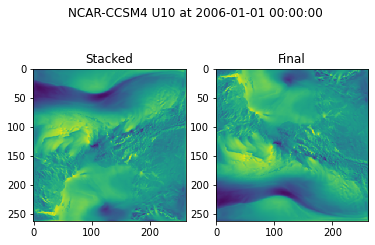

In [25]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("NCAR-CCSM4 U10 at 2006-01-01 00:00:00")
ax1.imshow(test_stacked_arr, interpolation="none")
ax1.set_title("Stacked")
ax2.imshow(test_arr, interpolation="none")
ax2.set_title("Final")
plt.show()

So, to match properly, both grids need to be flipped vertically:

In [43]:
import numpy as np

lat_arr_flip = np.flip(lat_arr, 0)
lon_arr_flip = np.flip(lon_arr, 0)

print("flipped latitudes:\n", lat_arr_flip)
print("\nflipped longitudes:\n", lon_arr_flip)

flipped latitudes:
 [[65.58805  65.76864  65.94935  ... 65.95755  65.77684  65.59624 ]
 [65.57468  65.75516  65.93575  ... 65.943954 65.76335  65.58286 ]
 [65.55994  65.740295 65.92076  ... 65.928955 65.74848  65.568115]
 ...
 [37.506927 37.573433 37.639565 ... 37.642555 37.576443 37.509953]
 [37.369934 37.43616  37.50201  ... 37.504993 37.439156 37.372944]
 [37.233    37.29895  37.364525 ... 37.367493 37.301937 37.236   ]]

flipped longitudes:
 [[ 122.017746  122.04866   122.080055 ...  -66.08149   -66.05007
   -66.019135]
 [ 122.45432   122.48857   122.52335  ...  -66.52495   -66.49014
   -66.455864]
 [ 122.89038   122.927956  122.96611  ...  -66.96785   -66.92967
   -66.892075]
 ...
 [-177.95314  -177.78015  -177.60664  ... -126.40124  -126.227715
  -126.0547  ]
 [-177.86931  -177.69673  -177.52364  ... -126.48424  -126.31112
  -126.138504]
 [-177.786    -177.6138   -177.44112  ... -126.566734 -126.39402
  -126.22181 ]]


#### Include the grids in the final dataset

Now include the lat and lon grids as variables in a new final dataset:

In [44]:
new_ds = ds.assign_coords({"lat": (["yc", "xc"], lat_arr_flip), "lon": (["yc", "xc"], lon_arr_flip)})

print(new_ds)

<xarray.Dataset>
Dimensions:  (time: 8760, yc: 262, xc: 262)
Coordinates:
  * xc       (xc) float64 -2.61e+06 -2.59e+06 -2.57e+06 ... 2.59e+06 2.61e+06
  * yc       (yc) float64 -1.824e+05 -2.024e+05 ... -5.382e+06 -5.402e+06
  * time     (time) datetime64[ns] 2006-01-01 ... 2006-12-31T23:00:00
    lat      (yc, xc) float32 65.59 65.77 65.95 66.13 ... 37.43 37.37 37.3 37.24
    lon      (yc, xc) float32 122.0 122.0 122.1 122.1 ... -126.6 -126.4 -126.2
Data variables:
    u10      (time, yc, xc) float32 ...
Attributes:
    creation_date:    Sat May 13 13:02:24 AKDT 2017
    NCL_Version:      6.3.0
    system:           Linux n9 2.6.32-642.11.1.el6.686g0000.x86_64 #1 SMP Tue...
    Conventions:      None
    grib_source:      WRFDS_d01.2006-01-01_00.grib
    title:            NCL: convert-GRIB-to-netCDF
    reference_time:   2006-01-01 00:00:00
    proj_parameters:  +units=m +proj=stere +lat_ts=64.0 +lon_0=-152.0 +lat_0=...
    crs_wkt:          PROJCS["unnamed",GEOGCS["unnamed ellipse",

Write a sliced version (first day) of the new test dataset to `$BASE_DIR/include-latlon/u10_wrf_test_latlon.nc`, and pickle the arrays in a python dict there as well.

In [45]:
new_ds.sel(time="2006-01-01").to_netcdf(latlon_dir.joinpath("u10_wrf_test_latlon.nc"))

import pickle

latlon_grids = {"lat": lat_arr_flip, "lon": lon_arr_flip}
with open(latlon_dir.joinpath("latlon_grids.pickle"), "wb") as out_file:
    pickle.dump(latlon_grids, out_file)

### Include CRS info as well

Turns out the CRS info of the post-processed WRF data files isn't found when reading into QGIS and Panoply. Take for example a sample lightning file provided by Peter. Notice the presence of the CRS variable and the mtaching value of the `grid_mapping` attribute specified for the `strikes` variable: 

In [64]:
with xr.open_dataset(latlon_dir.joinpath("Alaska_lightning_19860101.nc")) as strikes_ds:
    print(strikes_ds)
    print("\n\nCRS variable:")
    print(strikes_ds["polar_stereographic"])
    print("\n\nvariable attributes:")
    print(strikes_ds["strikes"].attrs)

<xarray.Dataset>
Dimensions:              (y: 262, x: 262)
Coordinates:
    time                 datetime64[ns] ...
  * x                    (x) float64 -2.61e+06 -2.59e+06 ... 2.59e+06 2.61e+06
  * y                    (y) float64 -5.414e+06 -5.394e+06 ... -1.936e+05
    lat                  (y, x) float32 ...
    lon                  (y, x) float32 ...
Data variables:
    strikes              (y, x) float32 ...
    polar_stereographic  |S1 ...
Attributes:
    Conventions:  CF
    publication:  Bieniek, P. A., and Coauthors, 2020: Lightning Variability ...
    source:       Alaska Lightning Detection Network
    contact:      pbieniek-at-alaska.edu


CRS variable:
<xarray.DataArray 'polar_stereographic' ()>
array(b'', dtype='|S1')
Coordinates:
    time     datetime64[ns] ...
Attributes:
    grid_mapping_name:                      polar_stereographic
    straight_vertical_longitude_from_pole:  -152.0
    false_easting:                          0.0
    false_northing:                   

Some testing has shown that including these two pieces is sufficient for allowing QGIS and Panoply to recognize the CRS. So, this needs to be done in addition to including the lat/lon data.

# Ad hoc modification

Instead of modifying the pipeline to include these updates, it would be nice to update the files in place instead if posisble, since we are just adding a variable and an attribute. But the following test showed that it still takes a long time to write the file:

```
import time

tic = time.perf_counter()

# add the crs variable
crs_name = "polar_stereographic"
new_ds[crs_name] = strikes_ds[crs_name]
new_ds["u10"].attrs["grid_mapping"] = crs_name

new_ds.to_netcdf(latlon_dir.joinpath("u10_wrf_test2_latlon_crsvar.nc"), mode="a")

print(f"Write completed in {round(time.perf_counter() - tic)}s")
```

returns

```
Write completed in 114s
```

With negligible difference if `mode="a"` is unset. So it will be better practice to modify the "improve" step of the pipeline and re-run it, so that it can be re-implemented with minimal effort.

In [80]:
hourly_ds = xr.open_dataset("/rcs/project_data/wrf_data/hourly/snowc/SNOWC_wrf_hourly_gfdl_hist_1979.nc")

In [322]:
hourly_fix_ds = xr.open_dataset("/rcs/project_data/wrf_data/hourly_fix/snowc/snowc_hourly_wrf_ERA-Interim_historical_1979_test.nc")

In [121]:
hourly_fix_ds = xr.open_dataset("/rcs/project_data/wrf_data/hourly_fix/snowc/snowc_hourly_wrf_ERA-Interim_historical_1979.nc")

In [326]:
hourly_fix_ds.xc.values[:5]

array([-2610000., -2590000., -2570000., -2550000., -2530000.])

In [328]:
strikes_ds.polar_stereographic.attrs["inverse_flattening"]

298.257223563

<xarray.DataArray 'x' (x: 262)>
array([-2610000., -2590000., -2570000., ...,  2570000.,  2590000.,  2610000.])
Coordinates:
    time     datetime64[ns] 1986-01-01
  * x        (x) float64 -2.61e+06 -2.59e+06 -2.57e+06 ... 2.59e+06 2.61e+06
Attributes:
    standard_name:  projection_x_coordinate
    long_name:      x coordinate of projection
    units:          m

## WRF Projection

Trying to figure out the WRF projection. Just starting by simply trying to transform a WRF-generated lat/lon and see if it matches the x/y coordinates created. The top-left lat/lon coordindates of the lightning data file given by Peter are:

```
lat: 37.233
lon: -177.786
```
and the top-left x/y coordinates in the lightning file are:
```
y: -5413582.2906
x: -2610000.0
```
and the corresponding x/y in the post-processed WRF are:

In [182]:
print(f"y: {hourly_fix_ds.yc.values[-1]}")
print(f"x: {hourly_fix_ds.xc.values[0]}")

y: -5402425.477371664
x: -2610000.0


Compare these to reprojections performed using the CRS info from each file. First, the AWS WRF:

In [217]:
from pyproj import Transformer
from pyproj.crs import CRS

#wgs84_proj = pyproj.Proj(proj='latlong', datum='WGS84')
wgs84_proj = pyproj.Proj("+proj=latlong +datum=WGS84")
aws_wrf_proj = pyproj.Proj(hourly_fix_ds.attrs["proj_parameters"])

# transform top-left lat/lon centroid to current WRF projection
transformer = Transformer.from_proj(wgs84_proj, aws_wrf_proj)

transformer.transform(-177.786, 37.233)

(-2609991.3830215335, -5402394.895587506)

In [202]:
cen_lon = raw_ds.CEN_LON
cen_lat = raw_ds.CEN_LAT

In [212]:
transformer = Transformer.from_proj(wgs84_proj, aws_wrf_proj)
e, n = transformer.transform(cen_lon, cen_lat)
x0 = -(nx - 1) / 2.0 * dx + e
y0 = -(ny - 1) / 2.0 * dy + n


In [340]:
aws_wrf_crs = CRS.from_proj4(aws_wrf_proj.definition_string())
aws_wrf_crs.to_wkt()

'PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",ELLIPSOID["unknown",6370000,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],CONVERSION["unknown",METHOD["Polar Stereographic (variant B)",ID["EPSG",9829]],PARAMETER["Latitude of standard parallel",64,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8832]],PARAMETER["Longitude of origin",-152,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8833]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["(E)",south,MERIDIAN[90,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],ORDER[1],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["(N)",south,MERIDIAN[180,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],ORDER[2],LENGTHUNIT["metre",1,ID["EPSG",9001]]]]'

In [342]:
aws_wrf_crs.to_cf()

{'crs_wkt': 'PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",ELLIPSOID["unknown",6370000,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],CONVERSION["unknown",METHOD["Polar Stereographic (variant B)",ID["EPSG",9829]],PARAMETER["Latitude of standard parallel",64,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8832]],PARAMETER["Longitude of origin",-152,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8833]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["(E)",south,MERIDIAN[90,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],ORDER[1],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["(N)",south,MERIDIAN[180,ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],ORDER[2],LENGTHUNIT["metre",1,ID["EPSG",9001]]]]',
 'semi_major_axis': 6370000.0,
 'semi_minor_axis': 6370000.0,
 'inverse_flattening': 0.0

In [200]:
# and working backwards
transformer = Transformer.from_proj(hourly_fix_ds.attrs["proj_parameters"], wgs84_proj)

test_lon, test_lat = transformer.transform(-2610000.0, -5402425.477371664)
print((test_lon, test_lat))
#print("Difference from original

(-177.7859470529445, 37.23276213367283)


Next, the lightning file:

In [195]:
# transform top-left lat/lon centroid to current WRF projection
lightning_wrf_crs = CRS.from_wkt(strikes_ds.polar_stereographic.attrs["spatial_ref"])

transformer = Transformer.from_crs(CRS.from_epsg(4326), lightning_wrf_crs)

transformer.transform(37.233, -177.786)

(-2615253.018883408, -5413285.902702526)

<function pyproj.crs.crs.CRS.from_epsg(code: Union[str, int]) -> 'CRS'>

# Compare projections

Okay, idk what to do except try a couple of these different projections and compare based on error between the lat/lons from reprojecting the coordinates and the lat/lons from the WRF file. 

Here are the different projections at play:

- AWS WRF proj
- AWS WRF WKT
- lightning WRF proj
- lightning WRF WKT
- [Fabien Maussion WRF proj](https://fabienmaussion.info/2018/01/06/wrf-projection/) (FM proj)

To compare, define a function that takes the proj or WKT string and returns an image of differences along with an RMSE score.

In [360]:
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer
import math

# need lightning strikes ds
wrf_lats = strikes_ds.lat.values
wrf_lons = strikes_ds.lon.values

# need raw wrf ds
cen_lat = raw_ds.CEN_LAT
cen_lon = raw_ds.CEN_LON
dx, dy = raw_ds.DX, raw_ds.DY
nx, ny = raw_ds.dims['west_east'], raw_ds.dims['south_north']


def validate_wrf_proj(wrf_proj, derive_grid=True):
    """for a given CRS, create the grid and 
    reproject the values to WGS84 and compare 
    with WRF lat/lon grids
    """
    if isinstance(wrf_proj, pyproj.proj.Proj):
        wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')
        transformer = Transformer.from_proj(wgs_proj, wrf_proj, always_xy=True)
        back_transformer = Transformer.from_proj(wrf_proj, wgs_proj, always_xy=True)
    elif isinstance(wrf_proj, pyproj.crs.crs.CRS):
        print("WKT supplied...")
        transformer = Transformer.from_crs(4326, wrf_proj, always_xy=True)
        back_transformer = Transformer.from_crs(wrf_proj, 4326, always_xy=True)
    
    # derive the grid from the center e/n determined by CRS
    # Otherwise, use the e/n determined by AWS WRF CRS, 0.0 -2792425.477371664
    if derive_grid:
        e, n = transformer.transform(cen_lon, cen_lat)
        print("Derived center easting/northing:", e, n)
    else:
        e, n = 0.0, -2792425.477371664
        
    # Grid parameters
    # Down left corner of the domain
    x0 = -(nx-1) / 2. * dx + e
    y0 = -(ny-1) / 2. * dy + n
    # 2d grid
    xx, yy = np.meshgrid(np.arange(nx) * dx + x0, np.arange(ny) * dy + y0)
    
    # now transform back to lat/lons and compare with WRF outputs
    new_lons, new_lats = back_transformer.transform(xx, yy)
    squared_dists = ((wrf_lats - new_lats) ** 2) + ((wrf_lons - new_lons) ** 2)
        
    rmse = np.sqrt(np.mean(squared_dists))
    
    plt.imshow(np.sqrt(squared_dists))
    
    return rmse


### AWS WRF

Center easting/northing: 0.0 -2792425.477371664


1.374193900872439

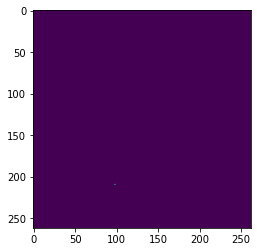

In [318]:
aws_wrf_proj = pyproj.Proj(hourly_fix_ds.attrs["proj_parameters"])

validate_wrf_proj(aws_wrf_proj)

### AWS WRF WKT

WKT supplied...
Center easting/northing: 0.0 -2792425.477371664


1.374193900872439

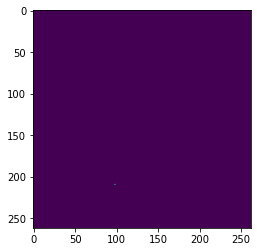

In [319]:
aws_wrf_wkt = CRS.from_wkt(hourly_fix_ds.attrs["crs_wkt"])

validate_wrf_proj(aws_wrf_wkt)

### Lightning WRF proj

Center easting/northing: 0.0 -2803583.5663868464


11.49183797616789

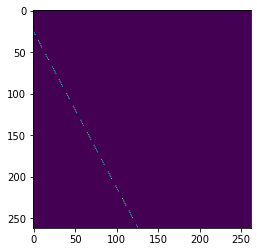

In [320]:
lightning_wrf_proj = pyproj.Proj(strikes_ds.polar_stereographic.attrs["spatial_ref"])

validate_wrf_proj(lightning_wrf_proj)

### Lightning WRF WKT

Center easting/northing: 0.0 -2803583.5663868464


11.49183797616789

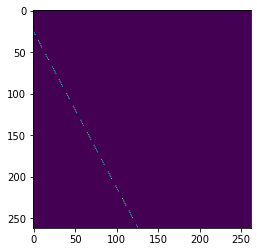

In [321]:
lightning_wrf_wkt = CRS.from_wkt(strikes_ds.polar_stereographic.attrs["spatial_ref"])

validate_wrf_proj(lightning_wrf_proj)

## Validate

Compare the new "improved" data to the old. First test run was with ACSNOW, moved originals to `hourly_fix/acsnow_old-for-validation`. Compare some files:

In [10]:
og_ds = xr.open_dataset("/rcs/project_data/wrf_data/hourly_fix/acsnow_old-for-validation/acsnow_hourly_wrf_ERA-Interim_historical_1979.nc")
new_ds = xr.open_dataset("/rcs/project_data/wrf_data/hourly_fix/acsnow/acsnow_hourly_wrf_ERA-Interim_historical_1979.nc")

print(og_ds, "\n\n", new_ds)

<xarray.Dataset>
Dimensions:  (time: 8736, yc: 262, xc: 262)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-02 ... 1979-12-31T23:00:00
  * xc       (xc) float64 -2.61e+06 -2.59e+06 -2.57e+06 ... 2.59e+06 2.61e+06
  * yc       (yc) float64 -1.824e+05 -2.024e+05 ... -5.382e+06 -5.402e+06
Data variables:
    acsnow   (time, yc, xc) float32 ...
Attributes:
    creation_date:    Mon Nov 25 10:32:57 AKST 2013
    NCL_Version:      6.1.2
    system:           Linux pacman1 2.6.32-358.14.1.el6.x86_64 #1 SMP Mon Jun...
    Conventions:      None
    grib_source:      WRFDS_d01.1979-01-02_00.grib
    title:            NCL: convert-GRIB-to-netCDF
    reference_time:   1979-01-02 00:00:00
    proj_parameters:  +units=m +proj=stere +lat_ts=64.0 +lon_0=-152.0 +lat_0=...
    restacked_by:     Scenarios Network for Alaska + Arctic Planning -- 2018
    crs_wkt:          PROJCS["unnamed",GEOGCS["unnamed ellipse",DATUM["unknow...
    SNAP_VERSION:     1.0 

 <xarray.Dataset>
Dimensions:         

In [15]:
import numpy as np

# verify variable equality for a view random dates
np.all([
    new_ds.acsnow.sel(time=f"1979-{date}T00:00:00").values == og_ds.acsnow.sel(time=f"1979-{date}T00:00:00").values 
    for date in ["01-02", "03-17", "09-14"]
])

True

Check that the new has the correct lat and lons:

In [19]:
hourly_ds = xr.open_dataset("/rcs/project_data/wrf_data/hourly/acsnow/ACSNOW_wrf_hourly_gfdl_hist_1979.nc")

np.all([np.all(new_ds[i].values == np.flipud(hourly_ds[i].values)) for i in ["lat", "lon"]])

True

Okay, looks good. Time to re-run them all. This is the command I will call: 

```
anaconda-project run python snap_data_wrf_prep/pipeline/wrap_run_improve_hourly_netcdf_structure.py -v acsnow cldfra cldfra_mid lh lwupb pcpc potevp qbot seaice smois snowh swupb t tslb  ubot  vbot albedo cldfra_high ght lwdnb lwupbc pcpnc psfc qvapor sh2o snow swdnb swupbc t2 u v canwat cldfra_low hfx lwdnbc omega pcpt q2 slp snowc swdnbc tbot tsk u10 v10
```


In [20]:
og_ds.close()

WKT supplied...


1.3777530475685285

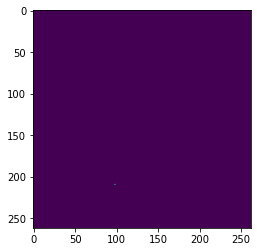

In [362]:
strikes_wkt = (
    'PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],'
    'AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["'
    'EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",64],'
    'PARAMETER["central_meridian",-152],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],'
    'UNIT["Meter",1]]'
)

validate_wrf_proj(CRS.from_wkt(strikes_wkt), derive_grid=False)

In [363]:
aws_wrf_proj

Proj('+proj=stere +lat_0=90 +lat_ts=64 +lon_0=-152 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs', preserve_units=True)

In [72]:
import os
import time


True

In [71]:
import time

time.time()

1634945266.8546836

In [70]:
ls -l /rcs/project_data/wrf_data/hourly/lh/LH_wrf_hourly_gfdl_rcp85_2100.nc

-rw-rw-r--. 1 snap-smb dyndown 876165329 Mar  7  2018 /rcs/project_data/wrf_data/hourly/lh/LH_wrf_hourly_gfdl_rcp85_2100.nc


In [270]:
back_transformer = Transformer.from_proj(aws_wrf_proj, wgs_proj, always_xy=True)

back_transformer.transform(-1610000, -182425.47737166)

(124.4644848621036, 74.74003853400863)

In [272]:
np.sqrt

<ufunc 'sqrt'>

In [257]:
xx, yy = validate_wrf_proj(aws_wrf_proj)

0.0 -2792425.477371664


In [251]:
wrf_proj

Proj('+proj=stere +lat_0=63.9999885559082 +lon_0=-152 +k=1 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs', preserve_units=True)

In [250]:
aws_wrf_proj

Proj('+proj=stere +lat_0=90 +lat_ts=64 +lon_0=-152 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs', preserve_units=True)

In [178]:
hourly_fix_ds.attrs["proj_parameters"]

'+units=m +proj=stere +lat_ts=64.0 +lon_0=-152.0 +lat_0=90.0 +x_0=0 +y_0=0 +a=6370000 +b=6370000'

In [150]:
raw_ds = xr.open_dataset("/workspace/Shared/Tech_Projects/wrf_data/project_data/wrf_raw_output_example/wrfout_d01_2025-07-10_00:00:00")

In [354]:
# Creating the WRF projection based on https://fabienmaussion.info/2018/01/06/wrf-projection/
import pyproj

wrf_proj = pyproj.Proj(proj="stere",
                       lat_1=raw_ds.TRUELAT1, lat_2=raw_ds.TRUELAT2,
                       lat_0=raw_ds.MOAD_CEN_LAT, lon_0=raw_ds.STAND_LON,
                       a=6370000, b=6370000) 


In [355]:
wrf_proj

Proj('+proj=stere +lat_0=63.9999885559082 +lon_0=-152 +k=1 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs', preserve_units=True)

In [356]:
CRS.from_proj4(wrf_proj.definition_string()).to_wkt()


'PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",ELLIPSOID["unknown",6370000,0,LENGTHUNIT["metre",1,ID["EPSG",9001]]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]]],CONVERSION["unknown",METHOD["Stereographic"],PARAMETER["Latitude of natural origin",63.9999885559082,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8801]],PARAMETER["Longitude of natural origin",-152,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8802]],PARAMETER["Scale factor at natural origin",1,SCALEUNIT["unity",1],ID["EPSG",8805]],PARAMETER["False easting",0,LENGTHUNIT["metre",1],ID["EPSG",8806]],PARAMETER["False northing",0,LENGTHUNIT["metre",1],ID["EPSG",8807]]],CS[Cartesian,2],AXIS["(E)",east,ORDER[1],LENGTHUNIT["metre",1,ID["EPSG",9001]]],AXIS["(N)",north,ORDER[2],LENGTHUNIT["metre",1,ID["EPSG",9001]]]]'

In [345]:
raw_ds.TRUELAT1

64.0

In [230]:
wrf_proj

Proj('+proj=stere +lat_0=63.9999885559082 +lon_0=-152 +k=1 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs', preserve_units=True)

In [231]:
aws_wrf_proj

Proj('+proj=stere +lat_0=90 +lat_ts=64 +lon_0=-152 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs', preserve_units=True)

In [166]:
# Easting and Northings of the domains center point
wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')

transformer = Transformer.from_proj(4326, wrf_proj)
e, n = transformer.transform(raw_ds.CEN_LAT, raw_ds.CEN_LON)

# Grid parameters
dx, dy = raw_ds.DX, raw_ds.DY
nx, ny = raw_ds.dims['west_east'], raw_ds.dims['south_north']
# Down left corner of the domain
x0 = -(nx-1) / 2. * dx + e
y0 = -(ny-1) / 2. * dy + n
# 2d grid
xx, yy = np.meshgrid(np.arange(nx) * dx + x0, np.arange(ny) * dy + y0)


In [ ]:
import matplotlib.pyplot as plt

transformer = Transformer.from_proj(wrf_proj, 4326)
our_lons, our_lats = transformer.transform(yy, xx)

ds['DIFF'] = np.sqrt((our_lons - ds.XLONG_M)**2 + (our_lats - ds.XLAT_M)**2)
ds.salem.quick_map('DIFF', cmap='Reds');

In [177]:
wrf_proj

Proj('+proj=stere +lat_0=63.9999885559082 +lon_0=-152 +k=1 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs', preserve_units=True)

In [ ]:
'+proj=stere +lat_0=63.9999885559082 +lon_0=-152 +k=1 +x_0=0 +y_0=0 +R=6370000 +units=m +no_defs'

In [3]:
(
    "#!/bin/sh\n"
    + "#SBATCH --nodes=1\n"
    + f"#SBATCH --cpus-per-task={8}\n"
    + "#SBATCH --account=snap\n"
    + "#SBATCH --mail-type=FAIL\n"
    + f"#SBATCH --mail-user={'test'}\n"
    + "#SBATCH -p main\n"
    + 'eval "$(conda shell.bash hook)"'
)

'#!/bin/sh\n#SBATCH --nodes=1\n#SBATCH --cpus-per-task=8\n#SBATCH --account=snap\n#SBATCH --mail-type=FAIL\n#SBATCH --mail-user=test\n#SBATCH -p main\neval "$(conda shell.bash hook)"'

In [3]:
"this" + ' that'

'this that'

In [142]:
import pandas as pd

print("Minimum y-coordinate values:")
pd.DataFrame([[hourly_fix_ds.yc.values.min(), -5413582.2906], [hourly_fix_ds.yc.values.max(), -193582.2906]], columns=["test", "lightning"], index=["min", "max"])


Minimum y-coordinate values:


,test,lightning
min,-5.402425e+06,-5.413582e+06
max,-1.824255e+05,-1.935823e+05


In [2]:
# save slice of test file to be transferred to local

import xarray as xr

ds = xr.open_dataset("/rcs/project_data/wrf_data/hourly_fix/snowc/snowc_hourly_wrf_ERA-Interim_historical_1979_test.nc")

new_ds = ds.sel(time="1979-01-03T00:00:00")

new_ds.to_netcdf("/atlas_scratch/kmredilla/WRF/snowc_hourly_wrf_ERA-Interim_historical_19790103_test.nc")

In [28]:
# evaluate an error to compare lh gfdl 2100 file

import xarray as xr

ds = xr.load_dataset("/rcs/project_data/wrf_data/hourly/lh/LH_wrf_hourly_gfdl_rcp85_2100.nc")

In [10]:
new_ds = xr.load_dataset("/rcs/project_data/wrf_data/hourly_fix/lh/lh_hourly_wrf_GFDL-CM3_rcp85_2100.nc")

In [19]:
import numpy as np

results = [
    np.all(new_ds.lat.values == np.flipud(ds.lat.values)),
    np.all(new_ds.lon.values == np.flipud(ds.lon.values)),
    np.all(new_ds.lh.sel(time="2100-01-01T00:00:00").values == np.flipud(ds.LH.sel(time="2100-01-01T00:00:00").values)),
    np.all(new_ds.lh.sel(time="2100-02-05T05:00:00").values == np.flipud(ds.LH.sel(time="2100-02-05T05:00:00").values)),
    np.all(new_ds.lh.sel(time="2100-05-23T13:00:00").values == np.flipud(ds.LH.sel(time="2100-05-23T13:00:00").values)),
    np.all(new_ds.lh.sel(time="2100-12-31T23:00:00").values == np.flipud(ds.LH.sel(time="2100-12-31T23:00:00").values))
]

KeyError: '2100-12-31T23:00:00'

In [88]:
ls /rcs/project_data/wrf_data/hourly_fix/t/ -ltr

total 4288879616
-rw-rw----. 1 snap-smb dyndown 14706661790 Apr 19  2019 t_hourly_wrf_ERA-Interim_historical_1979.nc
-rw-rw----. 1 snap-smb dyndown 14781621143 Apr 19  2019 t_hourly_wrf_ERA-Interim_historical_1980.nc
-rw-rw----. 1 snap-smb dyndown 14754278254 Apr 19  2019 t_hourly_wrf_ERA-Interim_historical_1981.nc
-rw-rw----. 1 snap-smb dyndown 14771904823 Apr 19  2019 t_hourly_wrf_ERA-Interim_historical_1982.nc
-rw-rw----. 1 snap-smb dyndown 14709071962 Apr 19  2019 t_hourly_wrf_ERA-Interim_historical_1983.nc
-rw-rw----. 1 snap-smb dyndown 14775950387 Apr 19  2019 t_hourly_wrf_ERA-Interim_historical_1984.nc
-rw-rw----. 1 snap-smb dyndown 14725806678 Apr 19  2019 t_hourly_wrf_ERA-Interim_historical_1985.nc
-rw-rw----. 1 snap-smb dyndown 14760948072 Apr 19  2019 t_hourly_wrf_ERA-Interim_historical_1986.nc
-rw-rw----. 1 snap-smb dyndown 14735570323 Apr 19  2019 t_hourly_wrf_ERA-Interim_historical_1987.nc
-rw-rw----. 1 snap-smb dyndown 14819037946 Apr 19  2019 t_hourly_wrf_ERA-Interim_hi

In [91]:
ls /rcs/project_data/wrf_data/wind-issue/hourly/u/ -l

total 4356777984
lrwxrwxrwx. 1 snap-smb dyndown          67 Apr 14  2021 U_wrf_hourly_ccsm_hist_1970.nc -> /rcs/project_data/WRF_DATA_SEP2019/u/U_wrf_hourly_ccsm_hist_1970.nc
-rw-rw----. 1 snap-smb dyndown 22938248687 Apr 14  2021 U_wrf_hourly_ccsm_hist_1971.nc
-rw-rw----. 1 snap-smb dyndown 22843553492 Apr 14  2021 U_wrf_hourly_ccsm_hist_1972.nc
-rw-rw----. 1 snap-smb dyndown 22885634907 Apr 14  2021 U_wrf_hourly_ccsm_hist_1973.nc
-rw-rw----. 1 snap-smb dyndown 22941989424 Apr 14  2021 U_wrf_hourly_ccsm_hist_1974.nc
-rw-rw----. 1 snap-smb dyndown 22781806963 Apr 14  2021 U_wrf_hourly_ccsm_hist_1975.nc
-rw-rw----. 1 snap-smb dyndown 22918736959 Apr 14  2021 U_wrf_hourly_ccsm_hist_1976.nc
-rw-rw----. 1 snap-smb dyndown 22910722266 Apr 14  2021 U_wrf_hourly_ccsm_hist_1977.nc
-rw-rw----. 1 snap-smb dyndown 22920101471 Apr 15  2021 U_wrf_hourly_ccsm_hist_1978.nc
-rw-rw----. 1 snap-smb dyndown 22913107795 Apr 15  2021 U_wrf_hourly_ccsm_hist_1979.nc
-rw-rw----. 1 snap-smb dyndown 22895816201

In [79]:
# check that file is older than a week
os.path.getmtime("/rcs/project_data/wrf_data/hourly_fix/t/t_hourly_wrf_NCAR-CCSM4_historical_1986.nc") < (time.time() - (60 ** 2 *24 * 7))

True

In [74]:
ds = xr.open_dataset("/rcs/project_data/wrf_data/hourly_fix/t2/t2_hourly_wrf_ERA-Interim_historical_2004.nc")


In [77]:
ls -l /rcs/project_data/wrf_data/hourly_fix/t2/t2_hourly_wrf_ERA-Interim_historical_2004.nc

-rw-rw----. 1 snap-smb dyndown 1223328158 Mar 13  2019 /rcs/project_data/wrf_data/hourly_fix/t2/t2_hourly_wrf_ERA-Interim_historical_2004.nc


In [59]:
ds = xr.open_dataset("/workspace/Shared/Tech_Projects/wrf_data/project_data/include-latlon/snowc_hourly_wrf_GFDL-CM3_historical_2006.nc")

In [ ]:
ds = xr.open_dataset("/rcs/project_data/wrf_data/hourly/t/T_hourly_wrf_ERA-Interim_historical_2004.nc")


In [65]:
ls /rcs/project_data/wrf_data/hourly/

T2_wrf_hourly_ccsm_hist_1970.nc    T2_wrf_hourly_era_interim_1998.nc
T2_wrf_hourly_ccsm_hist_1971.nc    T2_wrf_hourly_era_interim_1999.nc
T2_wrf_hourly_ccsm_hist_1972.nc    T2_wrf_hourly_era_interim_2000.nc
T2_wrf_hourly_ccsm_hist_1973.nc    T2_wrf_hourly_era_interim_2001.nc
T2_wrf_hourly_ccsm_hist_1974.nc    T2_wrf_hourly_era_interim_2002.nc
T2_wrf_hourly_ccsm_hist_1975.nc    T2_wrf_hourly_era_interim_2003.nc
T2_wrf_hourly_ccsm_hist_1976.nc    T2_wrf_hourly_era_interim_2004.nc
T2_wrf_hourly_ccsm_hist_1977.nc    T2_wrf_hourly_era_interim_2005.nc
T2_wrf_hourly_ccsm_hist_1978.nc    T2_wrf_hourly_era_interim_2006.nc
T2_wrf_hourly_ccsm_hist_1979.nc    T2_wrf_hourly_era_interim_2007.nc
T2_wrf_hourly_ccsm_hist_1980.nc    T2_wrf_hourly_era_interim_2008.nc
T2_wrf_hourly_ccsm_hist_1981.nc    T2_wrf_hourly_era_interim_2009.nc
T2_wrf_hourly_ccsm_hist_1982.nc    T2_wrf_hourly_era_interim_2010.nc
T2_wrf_hourly_ccsm_hist_1983.nc    T2_wrf_hourly_era_interim_2011.nc
T2_wrf_hourly_ccsm_hist_1984.nc   